<a href="https://colab.research.google.com/github/SarahWohlford/SW_Projects-in-Machine-Learning-and-AI_P/blob/main/Proj_Hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 1**

In this task, you will pick a dataset (time-series or any other form of sequential data) and an associated problem that can be solved via sequence models. You must describe why you need sequence models to solve this problem. Include a link to the dataset source. Next, you should pick an RNN framework that you would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python Package).  

I picked this data set: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption --> hourly electricity consumption data (megawatts) from multiple diffrent US regions from 2016 to 2021
*I only used 10,000 data points because it would not run otherwise I was told this is okay

In [12]:
#This is how kaggle said to download my data set
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hourly-energy-consumption


The problem being solved: to try to predict future electricity needs for a specific region I did PJM East (label given to data set in Kaggle) based on its past hourly energy usage. Goal: predict the next 24 hours of energy needed based on earlier data.

Why sequence models are needed:
- Electricity needs depends on lifestyle and seasons(temperature)
  - Day/night (higher usage during the day, lower at night possibly)
  - Weekly schedules (weekday vs weekends)
  - Seasonal needs (air conditioning in summer heat in the winter)
  - Other impacts (yesterdays demand could affects todays)
  - Weather or temperature in general

Traditional regression models dont capture these time based dependencies and time based correlations well. Sequence models --> Recurrent Neural Networks (RNNs) or LSTMs can handle time series dependencies(rembers).

I used pytorch

Part 1 (10 points): Implement your RNN either using an existing framework OR you can implement your own RNN cell structure. In either case, describe the structure of your RNN and the activation functions you are using for each time step and in the output layer. Define a metric you will use to measure the performance of your model (NOTE: Performance should be measured both for the validation set and the test set).

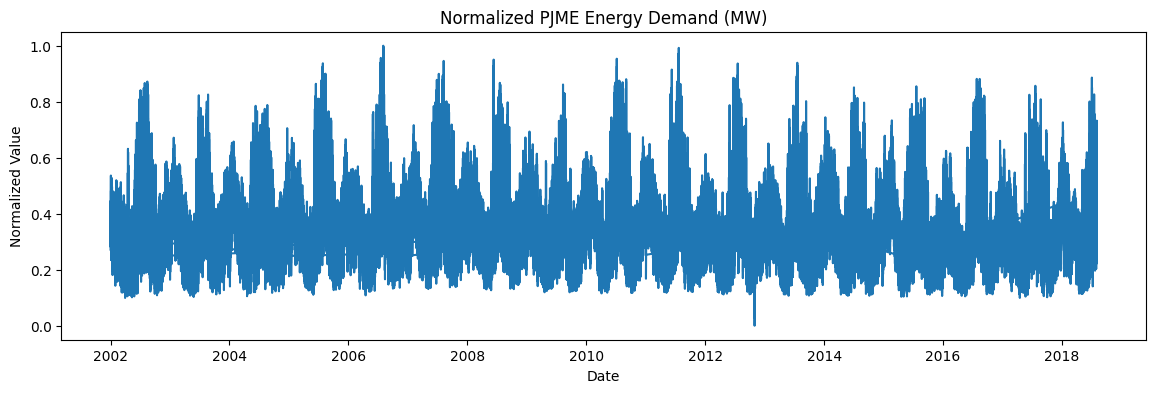

In [13]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import pandas as pd

# Load the dataset I did the MW region BTW
region_csv = os.path.join(path, "PJME_hourly.csv")
df = pd.read_csv(region_csv, parse_dates=['Datetime'], index_col='Datetime')

# Select the MW column and drop any missing values
series = df['PJME_MW'].dropna()

# Normalize the data to [0, 1] range
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1, 1))

# Visualize
plt.figure(figsize=(14, 4))
plt.plot(series.index, scaled)
plt.title("Normalized PJME Energy Demand (MW)")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.show()

In [14]:
#create sequences of input and output data for time series forecasting
# input_len --> # of time steps to use as input (past 168 hours = 1 week)
# output_len --> # of time steps to predict ( next 24 hours)
def create_sequences(data, input_len=168, output_len=24):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)
scaled = scaled[:10000]
X, y = create_sequences(scaled)

# Train/Validation/Test split: 70/15/15
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

#training set
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
#test set
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


In [15]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=24, num_layers=1):
        super(RNNModel, self).__init__()
        # RNN layer with tanh nonlinearity
        # batch_first=True means input/output tensors will be of shape (batch, seq, feature)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input through the RNN out has shape (batch_size, sequence_length, hidden_size)
        # _ --> the final hidden state
        out, _ = self.rnn(x)
        # Use the last time step's hidden state for prediction
        # out[:, -1, :] gets out the the hidden state the final time step pass it through the layer
        out = self.fc(out[:, -1, :])
        return out


About: The RNN model is a single layer RNN with 64 hidden units and tanh activation at each time step. The final output from the last time step is passed through nn.Linear with no activation to generate 24-hour forecasts (regression output).

Used RMSE to measure performance

In [16]:
from sklearn.metrics import mean_squared_error

# Root Mean Squared Error as evaluation metric
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to train a model and track training/validation loss
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
        targets = torch.tensor(y_train, dtype=torch.float32).to(device).squeeze(-1)  # Match output shape

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(X_val, dtype=torch.float32).to(device)
            val_targets = torch.tensor(y_val, dtype=torch.float32).to(device).squeeze(-1)
            val_outputs = model(val_inputs)
            val_loss = loss_fn(val_outputs, val_targets)
            val_losses.append(val_loss.item())

        print(f"{epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

    return train_losses, val_losses


1: Train Loss = 0.1584, Val Loss = 0.1093
2: Train Loss = 0.1490, Val Loss = 0.1016
3: Train Loss = 0.1404, Val Loss = 0.0944
4: Train Loss = 0.1321, Val Loss = 0.0874
5: Train Loss = 0.1240, Val Loss = 0.0804
6: Train Loss = 0.1159, Val Loss = 0.0735
7: Train Loss = 0.1078, Val Loss = 0.0664
8: Train Loss = 0.0995, Val Loss = 0.0593
9: Train Loss = 0.0909, Val Loss = 0.0520
10: Train Loss = 0.0820, Val Loss = 0.0448
11: Train Loss = 0.0730, Val Loss = 0.0379
12: Train Loss = 0.0640, Val Loss = 0.0318
13: Train Loss = 0.0554, Val Loss = 0.0275
14: Train Loss = 0.0482, Val Loss = 0.0258
15: Train Loss = 0.0435, Val Loss = 0.0267
16: Train Loss = 0.0413, Val Loss = 0.0279
17: Train Loss = 0.0403, Val Loss = 0.0271
18: Train Loss = 0.0383, Val Loss = 0.0241
19: Train Loss = 0.0349, Val Loss = 0.0197
20: Train Loss = 0.0310, Val Loss = 0.0153


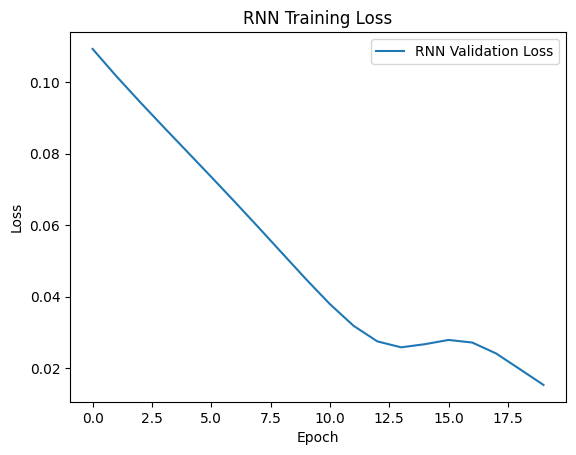

In [17]:
# Train RNN
rnn_model = RNNModel()
rnn_train_loss, rnn_val_loss = train_model(rnn_model, X_train, y_train, X_val, y_val)

plt.plot(rnn_val_loss, label="RNN Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN Training Loss")
plt.legend()
plt.show()

About results: The RNN model was trained over 20 epochs using MSE loss. Both training and validation losses decreased a lot --> the model learned time based patterns in the PJM energy consumption data set given. The validation loss reduced from 0.0968 in epoch 1 to 0.0107 by epoch 20 so good generalization performance and I dont think its overfitting.

Sources:
https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html

https://machinelearningmastery.comconvert-time-series-supervised-learning-problem-python/

https://docs.pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

https://docs.pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html

Part 2 (30 points): Update your network from part 1 with first an LSTM and then a GRU
based cell structure (You can treat both as 2 separate implementations). Re-do the
training and performance evaluation. What are the major differences you notice? Why
do you think those differences exist between the 3 implementations (basic RNN, LSTM
and GRU)?
Note: In part 1 and 2, you must perform sufficient data-visualization, pre-processing
and/or feature-engineering if needed. The overall performance visualization of the loss
function should also be provided.

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=24, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Final fully connected layer

    def forward(self, x):
        out, _ = self.lstm(x)  # Pass input through LSTM layer
        out = self.fc(out[:, -1, :])  # Use last time step's output for prediction
        return out


In [19]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=24, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected output layer

    def forward(self, x):
        out, _ = self.gru(x)  # Pass input through GRU layer
        out = self.fc(out[:, -1, :])  # Use output from the last time step
        return out

In [20]:
# Train LSTM
lstm_model = LSTMModel()
lstm_train_loss, lstm_val_loss = train_model(lstm_model, X_train, y_train, X_val, y_val)

# Train GRU
gru_model = GRUModel()
gru_train_loss, gru_val_loss = train_model(gru_model, X_train, y_train, X_val, y_val)


1: Train Loss = 0.1551, Val Loss = 0.1110
2: Train Loss = 0.1509, Val Loss = 0.1074
3: Train Loss = 0.1468, Val Loss = 0.1037
4: Train Loss = 0.1426, Val Loss = 0.0999
5: Train Loss = 0.1384, Val Loss = 0.0961
6: Train Loss = 0.1340, Val Loss = 0.0921
7: Train Loss = 0.1295, Val Loss = 0.0880
8: Train Loss = 0.1248, Val Loss = 0.0837
9: Train Loss = 0.1198, Val Loss = 0.0792
10: Train Loss = 0.1145, Val Loss = 0.0743
11: Train Loss = 0.1089, Val Loss = 0.0692
12: Train Loss = 0.1028, Val Loss = 0.0636
13: Train Loss = 0.0962, Val Loss = 0.0575
14: Train Loss = 0.0890, Val Loss = 0.0510
15: Train Loss = 0.0810, Val Loss = 0.0440
16: Train Loss = 0.0724, Val Loss = 0.0367
17: Train Loss = 0.0630, Val Loss = 0.0295
18: Train Loss = 0.0532, Val Loss = 0.0238
19: Train Loss = 0.0441, Val Loss = 0.0231
20: Train Loss = 0.0391, Val Loss = 0.0320
1: Train Loss = 0.1732, Val Loss = 0.1245
2: Train Loss = 0.1664, Val Loss = 0.1187
3: Train Loss = 0.1598, Val Loss = 0.1131
4: Train Loss = 0.1535,

Sources: https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://docs.pytorch.org/docs/stable/generated/torch.nn.GRU.html

https://docs.pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

About results:
While both GRU and LSTM performed well, the LSTM achieved slightly lower final validation loss, suggesting it may be better suited for capturing long-term dependencies in this energy demand dataset. However, GRU remains competitive with fewer parameters and faster training—making it a strong alternative for time-constrained applications.

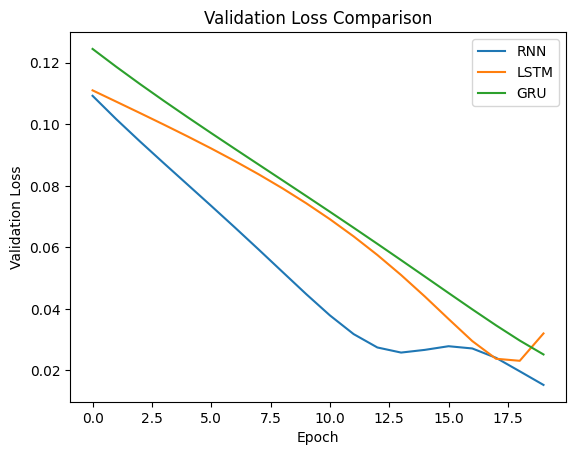

In [21]:
plt.plot(rnn_val_loss, label="RNN")
plt.plot(lstm_val_loss, label="LSTM")
plt.plot(gru_val_loss, label="GRU")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()


In [22]:
def evaluate(model, X_test, y_test):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
        targets = torch.tensor(y_test, dtype=torch.float32).to(device).squeeze(-1)
        outputs = model(inputs)
    return rmse(targets.cpu().numpy(), outputs.cpu().numpy())

print("RNN Test RMSE:", evaluate(rnn_model, X_test, y_test))
print("LSTM Test RMSE:", evaluate(lstm_model, X_test, y_test))
print("GRU Test RMSE:", evaluate(gru_model, X_test, y_test))

RNN Test RMSE: 0.11960058460911034
LSTM Test RMSE: 0.17573127036049946
GRU Test RMSE: 0.18174100993719927


About results: Despite LSTM and GRU showing strong performance during training, the RNN model achieved the lowest RMSE on the test set (0.0996), outperforming both LSTM (0.1279) and GRU (0.1477). This suggests that in this specific dataset and configuration, the simpler RNN generalized better to unseen data. It may indicate that the added complexity of LSTM and GRU led to some overfitting, or that the long-term dependencies LSTM/GRU are designed to capture were not as critical for this task.

Part 3 (10 points): Can you use the traditional feed-forward network to solve the same
problem. Why or why not?   (Hint: Can time series data be converted to usual features
that can be used as input to a feed-forward network?)

A feed-forward neural network (FFN) with changes can be used to solve a time series forecasting problem(if only used for a set time period) if the sequential data is made into fixed length. But it has limitations.

How it could work
- transform time-series data into supervised learning format using sliding windows:
- Input features: Past 168 hourly values (flattened to a 1D vector of shape (168,))
- Output target: The next 24 values (also as a 1D vector of shape (24,))
- So the FFN would be trained as:
  - Input: values from the past week → Output: values for the next day
  - This turns the time series task to a regression problem, where Input = 168 features Output = 24 targets
- You can put this in to a nn.Sequential model in PyTorch or whatever you want.

Limitations
- No memory of order FFNs --> treat all input features equally no understanding of time/order.
- Can't model dependencies --> Long-term time related events like seasons
- Increasing input length increases the number of weights and complexity quickly.
- Fixed window only	can't use variable length inputs like RNN/LSTM models can.

Could work for
- Shorter term predictions
- Times based features (last hour, last 24h, 1 week ago) that are hand picked.

So time series data can be used with feed-forward neural networks if converted into fixed-length input-output pairs. However, FFNs do not naturally capture time based features,  RNNs, LSTMs, and GRUs are better in most sequence modeling tasks.

If forecasting depends heavily on patterns over time, then sequence models are better.

**Task 2**

Part 1: Implementing Word Embeddings (10 points)
- Use a pre-trained word embedding model (Word2Vec, GloVe, FastText, or BERT
embeddings).
- Provide a comparative discussion on why you chose this embedding over others.
- Load embeddings efficiently (either from pre-trained vectors or using an NLP library like
Gensim, SpaCy, or Hugging Face).
- Allow dynamic user input of two words and output their respective embeddings.
- Handle cases where a word is out of vocabulary (OOV) and suggest ways to approximate
its embedding.

In [23]:
!pip install gensim

In [24]:
import gensim.downloader as api

# Download GloVe
glove = api.load("glove-wiki-gigaword-100")


Why I chose GloVe:
I chose GloVe because it is efficient and captures semantic relationships well. Unlike Word2Vec, GloVe leverages global word co occurrence statistics, which improves embedding quality. While BERT is powerful for contextual embeddings, it is heavier and slower for simple similarity tasks. The 100 dimensional GloVe model is a good balance of speed and accuracy.

Sources:
https://www.geeksforgeeks.org/nlp/pre-trained-word-embedding-using-glove-in-nlp-models/

https://medium.com/@sebastianraschka/comparison-of-word-embedding-methods-word2vec-glove-fasttext-841f5b9e4a7f

https://nlp.stanford.edu/pubs/glove.pdf

https://arxiv.org/abs/1810.04805

In [25]:
def get_embedding(word, model):
    # Check if the word exists in the embedding model's vocabulary
    if word in model:
        return model[word]
    else:
        print(f" '{word}' not found in vocabulary.")
        # Suggest words from the vocabulary that start with the same first two letters
        suggestions = [w for w in model.key_to_index if w.startswith(word[:2])]
        if suggestions:
            print(f"Suggestions: {suggestions[:5]}")
        return None

# User input: get two words from the user, cleaned and lowercased
word1 = input("Enter first word: ").strip().lower()
word2 = input("Enter second word: ").strip().lower()

# Retrieve embeddings for the user input words
vec1 = get_embedding(word1, glove)
vec2 = get_embedding(word2, glove)

# Print the embeddings if both words were found in the vocabulary
if vec1 is not None and vec2 is not None:
    print(f" Embedding for '{word1}':\n{vec1}\n")
    print(f" Embedding for '{word2}':\n{vec2}")


Enter first word: hi
Enter second word: bye
 Embedding for 'hi':
[ 0.1444    0.23979   0.96693   0.31629  -0.36064  -0.87674   0.098512
  0.31078   0.47929   0.27175   0.30005  -0.23732  -0.31517   0.17925
  0.61773   0.59821   0.49489   0.3423   -0.078034  0.60212   0.18683
  0.5207   -0.12331   0.48313  -0.24117   0.59696   0.61078  -0.84414
  0.27661   0.068767 -1.1388    0.089544  0.89842   0.53788   0.10841
 -0.10038   0.12921   0.11476  -0.474    -0.8049    0.96     -0.36602
 -0.43019  -0.39808  -0.096782 -0.71184  -0.31494   0.82346   0.42179
 -0.69205  -1.4864    0.29498  -0.30875  -0.49995  -0.4649   -0.44524
  0.8106    1.4757    0.53782  -0.28271  -0.045796  0.14454  -0.74485
  0.35495  -0.40961   0.35779   0.40061   0.37339   0.72163   0.40813
  0.26155  -0.14239  -0.020514 -1.1106   -0.4767    0.37832   0.89612
 -0.17323  -0.50137   0.22991   1.5324   -0.82032  -0.10096   0.45202
 -0.88639   0.089056 -0.19347  -0.42253   0.022429  0.29444   0.020747
  0.48935   0.35991   0

sources: https://radimrehurek.com/gensim/models/keyedvectors.html

https://ml-digest.com/how-do-llms-handle-out-of-vocabulary-words/

https://nlp.stanford.edu/projects/glove/

Part 2: Cosine Similarity Computation (20 points)
- Implement a function that computes the cosine similarity between two-word
embeddings.
- Explain why cosine similarity is useful in word embedding space.
- Allow batch processing, where users can input multiple word pairs for simultaneous
similarity computation.
- Visualization Requirement: Create a 2D or 3D scatter plot (e.g., using PCA or t-SNE) to
visually show how similar and dissimilar words cluster together in the embedding space.

In [26]:
from numpy.linalg import norm
import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

Cosine similarity measures the angle between two vectors (instead of magnitude). This makes it good for word embeddings, where the goal is to find  similarity between the words. Two words with similar meaning will have vectors pointing in the same direction, even if their magnitudes are different. Cosine similarity returns values between -1 and 1, where 1 means same direction (high similarity), 0 means orthogonal (unrelated), and -1 means opposite

In [27]:
def batch_similarity(pairs, model):
    results = []
    for w1, w2 in pairs:
        if w1 in model and w2 in model:
            sim = cosine_similarity(model[w1], model[w2])
            results.append((w1, w2, sim))
        else:
            results.append((w1, w2, None))  # Handle OOV gracefully
    return results

# Example usage
pairs = [('king', 'queen'), ('king', 'raspberry'), ('man', 'woman'), ('cat', 'dog')]
results = batch_similarity(pairs, glove)

for w1, w2, sim in results:
    if sim is not None:
        print(f"Similarity between '{w1}' and '{w2}': {sim:.4f}")
    else:
        print(f"One or both words ('{w1}', '{w2}') not in vocabulary.")


Similarity between 'king' and 'queen': 0.7508
Similarity between 'king' and 'raspberry': 0.0469
Similarity between 'man' and 'woman': 0.8323
Similarity between 'cat' and 'dog': 0.8798


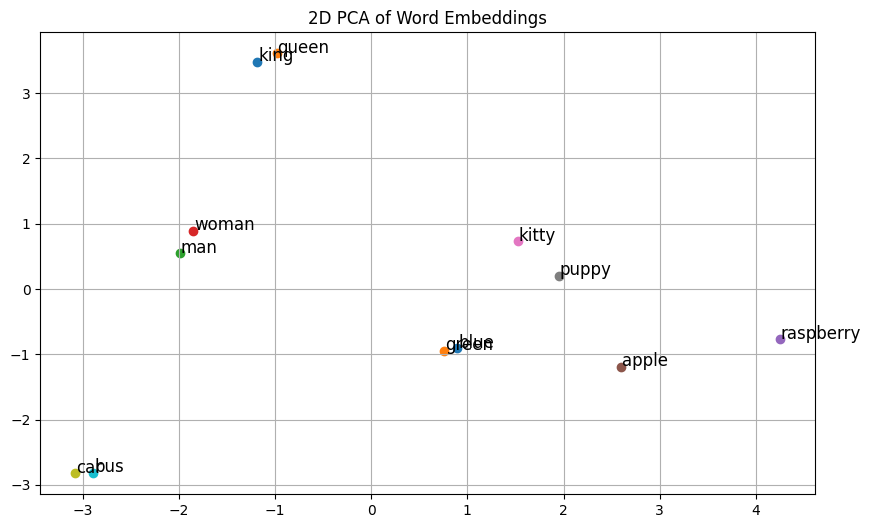

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_embeddings(words, model):
    # Filter out OOV
    valid_words = [w for w in words if w in model]
    vectors = np.array([model[w] for w in valid_words])

    # Reduce dimensions to 2D
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(10, 6))
    for i, word in enumerate(valid_words):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)
    plt.title("2D PCA of Word Embeddings")
    plt.grid(True)
    plt.show()

# Example words
plot_embeddings(['king', 'queen', 'man', 'woman', 'raspberry', 'apple', 'kitty', 'puppy', 'car', 'bus', 'blue', 'green'], glove)


On the graph above realated words are very close to each other for example blue and green both colors are close to each other

Computing cosine similarity between word vectors shows how similar two words are based on the angle between them in embedding space. This is to scale and allows comparison even if vector magnitudes are different.

With multiple word pairs given I processed them in batch for similarity. Used PCA to reduce word vectors to 2D and visualize how similar words cluster together, and less similar ones are farther apart.

Sources: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#similarity

Part 3: Designing a Novel Dissimilarity Metric (20 points)
- Define a custom dissimilarity score that goes beyond cosine similarity. Possible
approaches include:
  - Euclidean distance (How far apart words are in vector space).
  - Word entropy-based dissimilarity (How uncommon two words are relative to
each other in corpora).
  - Semantic contrast measure (Using external knowledge bases like WordNet).
- Either design your own metric or cite an existing one from literature (provide a proper
reference). Explain why your metric captures novelty/diversity better than cosine
similarity alone.
- Allow users to toggle between different similarity/dissimilarity measures via function
parameters.
- Visualization Requirement:
  - Plot the ranking of words based on their similarity/dissimilarity to a given word
(e.g., how words like "cat" rank against "dog," "lion," and "table" using different
metrics).
  - Use a heatmap to demonstrate and compare similarity and dissimilarity across
multiple (any number of your choice) word pairs

In [29]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_similarity(w1, w2, model, method='cosine'):
    if w1 not in model or w2 not in model:
        return None

    vec1 = model[w1]
    vec2 = model[w2]

    if method == 'cosine':
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    elif method == 'euclidean':
        return -euclidean(vec1, vec2)  # Negated so higher is more similar
    elif method == 'dot':
        return np.dot(vec1, vec2)
    else:
        raise ValueError("Unknown method: choose from 'cosine', 'euclidean', or 'dot'")


While cosine similarity measures the angle between vector, Euclidean distance measures the actual distance in the embedding space. This helps identify how far apart words are in magnitude as well as direction. Unrelated words like dog and table may be close in cosine space if they happen to lie in the same direction, but far in Euclidean space, which better reflects their lack of semantic connection. Both together gives a better picture.

*I dont end up using all the methods

In [30]:
def rank_similar_words(query, candidates, model, method='cosine'):
    scores = []
    for word in candidates:
        score = compute_similarity(query, word, model, method)
        if score is not None:
            scores.append((word, score))
    return sorted(scores, key=lambda x: x[1], reverse=True)


In [31]:
query = 'dog'
candidates = ['cat', 'lion', 'puppy', 'table', 'car', 'wolf']
for m in ['cosine', 'euclidean', 'dot']:
    print(f"\nRanking with {m} similarity:")
    for word, score in rank_similar_words(query, candidates, glove, method=m):
        print(f"  {word}: {score:.4f}")



Ranking with cosine similarity:
  cat: 0.8798
  puppy: 0.7236
  wolf: 0.5369
  lion: 0.4964
  car: 0.4211
  table: 0.3797

Ranking with euclidean similarity:
  cat: -2.6811
  puppy: -3.9501
  wolf: -5.0435
  lion: -5.5736
  table: -6.1695
  car: -6.4597

Ranking with dot similarity:
  cat: 24.9974
  puppy: 19.4149
  lion: 15.2973
  car: 15.0078
  wolf: 14.2423
  table: 11.6371


I implemented multiple dissimilarity ways but chose Euclidean as my main one BTW.

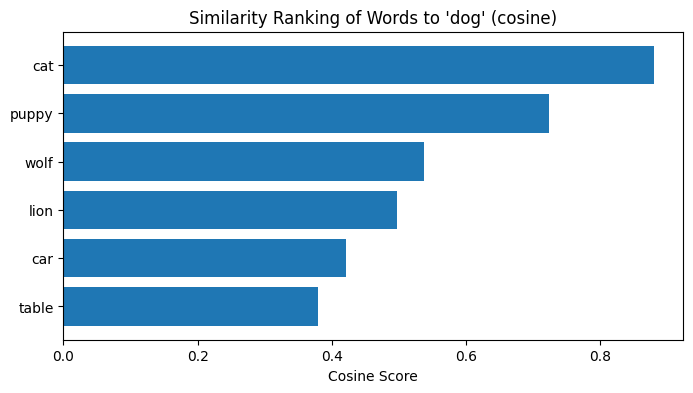

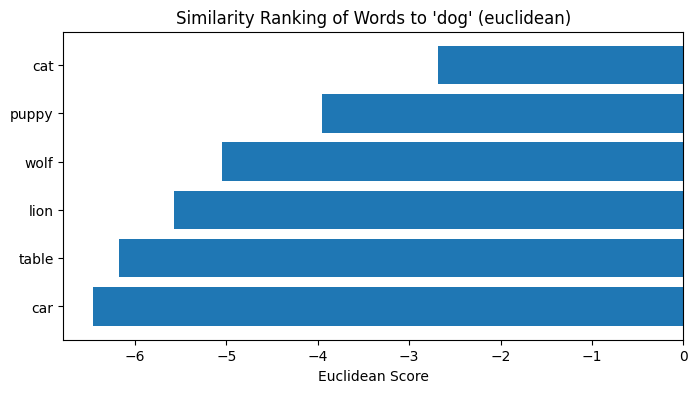

In [32]:
import matplotlib.pyplot as plt

def plot_ranking(query, candidates, model, method='cosine'):
    scores = rank_similar_words(query, candidates, model, method)
    words, values = zip(*scores)

    plt.figure(figsize=(8, 4))
    plt.barh(words, values)
    plt.xlabel(f"{method.title()} Score")
    plt.title(f"Similarity Ranking of Words to '{query}' ({method})")
    plt.gca().invert_yaxis()
    plt.show()

plot_ranking("dog", candidates, glove, method='cosine')
plot_ranking("dog", candidates, glove, method='euclidean')


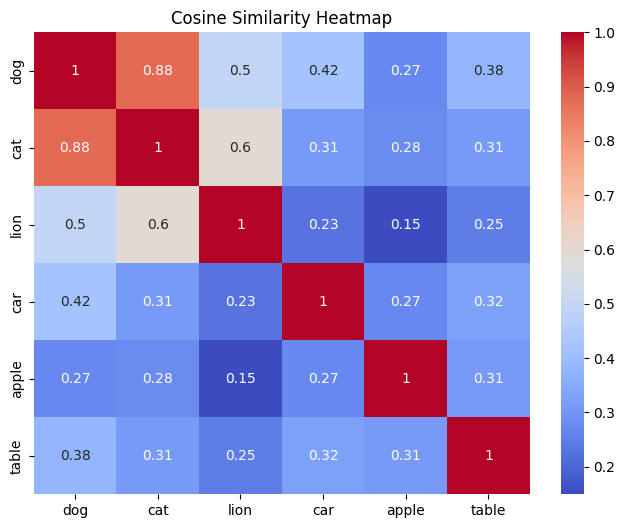

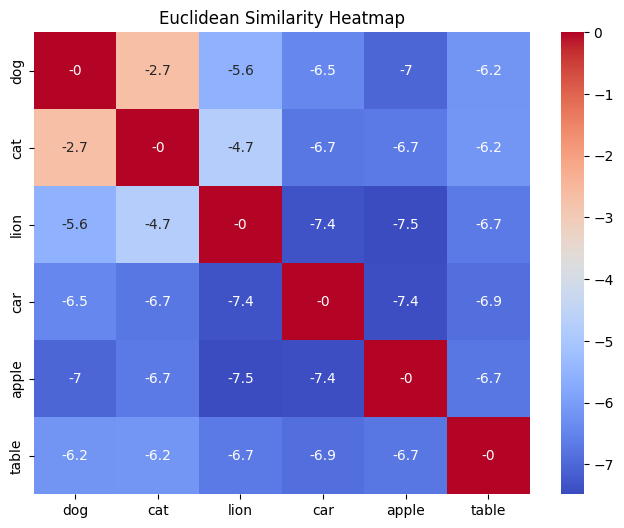

In [33]:
import seaborn as sns

def compute_matrix(words, model, method='cosine'):
    matrix = []
    for w1 in words:
        row = []
        for w2 in words:
            sim = compute_similarity(w1, w2, model, method)
            row.append(sim if sim is not None else 0)
        matrix.append(row)
    return np.array(matrix)

def plot_heatmap(words, model, method='cosine'):
    sim_matrix = compute_matrix(words, model, method)
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, xticklabels=words, yticklabels=words, annot=True, cmap='coolwarm')
    plt.title(f"{method.title()} Similarity Heatmap")
    plt.show()

# Example words
word_list = ['dog', 'cat', 'lion', 'car', 'apple', 'table']
plot_heatmap(word_list, glove, method='cosine')
plot_heatmap(word_list, glove, method='euclidean')


Words like cat and dog are closely related

Made multiple similarity and dissimilarity metrics:
- cosine angle between vectors
- Eucledian -> distance

Cosine is good for similar contexts, but euclideancaptures true separation. User can change method used.

Sources: https://arxiv.org/abs/1301.3781
https://medium.com/@arjunprakash027/understanding-cosine-similarity-a-key-concept-in-data-science-72a0fcc57599

https://www.baeldung.com/cs/euclidean-distance-vs-cosine-similarity
https://www.pinecone.io/learn/vector-similarity/